In [1]:
from connect import grid, get_random_enter_exit_point
import os
import numpy as np
import cv2 as cv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
import time
import torch.utils.data as Data
import torch.nn as nn
import random
from torch.nn.utils.rnn import pack_padded_sequence
from model import Encoder, Decoder

# sets device for model and PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

torch.manual_seed(0)
torch.cuda.manual_seed(0)


def transform(img, enter, esc):
    img = cv.resize(img, (512, 512), cv.INTER_NEAREST)
    img = img.astype(np.float32)[:, :, ::-1]
    img = img / 255.0
    img -= [0.485, 0.456, 0.406]
    img /= [0.229, 0.224, 0.225]
    img = img.transpose((2, 0, 1))
    img = torch.tensor(img, dtype=torch.float).reshape(1, 3, 512, 512)
    enter_point = torch.tensor(enter, dtype=torch.float)  # dim = 2
    esc_point = torch.tensor(esc, dtype=torch.float)  # dim = 2
    return img, enter_point, esc_point


def get_direction(grid_a, grid_b):
    dx, dy = grid_b[0]-grid_a[0], grid_b[1]-grid_a[1]
    direction = {(-1, 0): 'up', (1, 0): 'down',
                 (0, 1): 'right', (0, -1): 'left'}
    return (direction[(dx, dy)], direction[(-dx, -dy)])


def get_direction_list(grid_data):
    enter_list = []
    exit_list = []
    length = len(grid_data)
    for i in range(length-1):
        exit, enter = get_direction(grid_data[i], grid_data[i+1])
        enter_list.append(enter)
        exit_list.append(exit)
    enter_list.insert(0, get_direction(grid_data[0], grid_data[1])[1])
    exit_list.insert(-1, get_direction(grid_data[-2], grid_data[-1])[0])
    return enter_list, exit_list


def predict(decoder, encoder, img, enter, esc, max_len):
    img, enter, esc = transform(img, enter, esc)
    max_len = max_len
    batch_size = 1
    decoder.eval()
    encoder.eval()
    length = torch.full((1, 1), max_len, dtype=torch.long)
    # Move to device, if available
    img = img.to(device)  # (b,c,w,h)
    enter = enter.to(device)  # (b,2)
    esc = esc.to(device)  # (b,2)
    encoder_out = encoder(img)
    encoder_dim = encoder_out.size(-1)
    # Flatten image
    # (b, num_pixels, encoder_dim)
    encoder_out = encoder_out.view(1, -1, encoder_dim)
    num_pixels = encoder_out.size(1)  # for attention. not useful at the moment

    # Initialize LSTM state
    h, c, h_inv, c_inv = decoder.init_hidden_state(encoder_out, enter, esc)

    # Create tensors to hold two coordination predictions
    predictions_ord = torch.zeros((batch_size,max_len,2)).to(device)  # (b,max_len,2)
    predictions_inv = torch.zeros((batch_size,max_len,2)).to(device)  # (b,max_len,2)

    predictions_ord[:,0,:] = enter
    predictions_inv[:,max_len-1,:] = esc

    for t in range(max_len):
        h_a = torch.cat([h,h_inv],dim=1)
        h_b = torch.cat([h_inv,h],dim=1)
        c_a = torch.cat([c,c_inv],dim=1)
        c_b = torch.cat([c_inv,c],dim=1)

        #attention_weighted_encoding, alpha = decoder.attention(encoder_out,h_a)
        #attention_weighted_encoding_inv, alpha_inv = decoder.attention(encoder_out,h_b)
        #gate = decoder.sigmoid(decoder.f_beta(h_a))
        #gate_inv = decoder.sigmoid(decoder.f_beta(h_b))
        #attention_weighted_encoding = gate * attention_weighted_encoding
        #attention_weighted_encoding_inv = gate_inv * attention_weighted_encoding_inv

        # weight is attention (differ from var weights below)
        weight = F.softmax(decoder.attention(h_a)) # weight for each input pixels
        weight_inv = F.softmax(decoder.attention(h_b)) # (batch_size_t,n_pixels)

        h, c = decoder.decoder(
            torch.cat([decoder.position_embedding(predictions_ord[:,t,:]),encoder_out[:,t,:] * weight],dim=1),
            (h_a, c_a))  # (batch_size_t, decoder_dim)

        h_inv, c_inv = decoder.decoder_inv(
            torch.cat([decoder.position_embedding(predictions_inv[:,max_len-1-t,:]),encoder_out[:,t,:] * weight_inv],dim=1),
            (h_b, c_b))

        h = decoder.trans_h(h)
        c = decoder.trans_c(c)
        h_inv = decoder.trans_h(h_inv)
        c_inv = decoder.trans_c(c_inv)

        preds = decoder.fc(decoder.dropout(h))  # (batch_size_t, 2)
        preds_inv = decoder.fc(decoder.dropout(h_inv))
        if t < max_len - 1:
            predictions_ord[:, t + 1, :] = preds # (b,max_len,2)
            predictions_inv[:, max_len-2-t,:] = preds_inv

    ## weight scheme 1
    #first_part = [1]*int(max_len/2)
    #second_part = [0]*(max_len - int(max_len/2))
    #weights = np.array(first_part + second_part)
    #weights_inv = np.array(second_part + first_part)

    ## weight scheme 2
    weights = np.array([_ for _ in range(max_len)])
    weights = np.exp(-weights)
    weights_inv = weights[::-1]
    weights = np.vstack([weights,weights_inv])
    weights /= weights.sum(axis=0)
    weights_inv = weights[1,:]
    weights = weights[0,:]

    weights = torch.tensor(weights,dtype=torch.float).to(device).unsqueeze(0).unsqueeze(2)
    weights_inv = torch.tensor(weights_inv, dtype=torch.float).to(device).unsqueeze(0).unsqueeze(2)
    predictions = (predictions_ord * weights + predictions_inv * weights_inv)

    return predictions


def to_coordinate(name, pred):
    [i, j] = name.split('_')
    i, j = int(i), int(j)
    i = 31 - i
    pred = np.add(pred / 2, np.array([j, i]))
    # pred=np.array([[j, i]])
    pred = pred*np.array([0.0041962500000000125,0.0035684999999998634]) + np.array([-8.685367875, 41.12501625])
    return pred

In [2]:
torch.nn.Module.dump_patches = True
map_dir = '/home/zbl_2019/lzt/output_pic32/'
checkpoint = '/home/wxr/projects/Backup/waysguider_bi_lstm_new/checkpoint/checkpoint_best.pth'
#map_whole = cv.imread(map_name)
#map_grids = grid(map_whole)  # map_grids[point]; point = '1_2'
print('loading model ...')
checkpoint = torch.load(checkpoint)
decoder1 = checkpoint['decoder']
encoder1 = checkpoint['encoder']
encoder = Encoder().to(device)
decoder = Decoder(decoder_dim = 1024).to(device)

encoder.load_state_dict(encoder1.state_dict())
decoder.load_state_dict(decoder1.state_dict())



loading model ...


/home/wxr/en/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'model.Encoder' has changed. Tried to save a patch, but couldn't create a writable file Encoder.patch. Make sure it doesn't exist and your working directory is writable.
  warnings.warn(msg, SourceChangeWarning)
/home/wxr/en/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. Saved a reverse patch to Conv2d.patch. Run `patch -p0 < Conv2d.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/home/wxr/en/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. Saved a reverse patch to ReLU.patch. Run `patch -p0 < ReLU.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/home/wxr/en/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: sourc

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [113]:
#coding:utf-8
import os
import cv2 as cv
import os
import copy
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split


def visualize(img, seq, seq_gt, enter, esc):
    """
    visualize a output of validation epoch
    
    :param output_dir: a path, which will be created when not exists
    :param imgs: torch GPU Tensor of (b,c,w,h)
    :param seq: torch GPU Tensor of (b,max_len,2)
    :param enter: (b,2)
    :param esc: (b,2)
    :param length: (b,1)
    """
    
    d = 5

    img = img[...,::-1] #rgb --> bgr
    w, h, c = img.shape
    img = cv.copyMakeBorder(img, 5, 5, 5, 5, cv.BORDER_CONSTANT,value=[225,225,225])
    for j in range(len(seq)):
        m, n = int(h/2+seq[j,1]*(h/2-1)),int(h/2+seq[j,0]*(h/2-1))
        print(m, n)
#         m = h - m
#         n = h - n
#         m = h - m
#         m, n = n, m
        if seq[j,1] == 3:
            break

        img[-m-d:-m+d,n-d:n+d,:] = np.zeros_like(img[-m-d:-m+d,n-d:n+d,:])

    return img


def visualize_line(img, seq, seq_gt, enter, esc):
    """
    visualize a output of validation epoch
    
    :param output_dir: a path, which will be created when not exists
    :param imgs: torch GPU Tensor of (b,c,w,h)
    :param seq: torch GPU Tensor of (b,max_len,2)
    :param enter: (b,2)
    :param esc: (b,2)
    :param length: (b,1)
    """
    


    img = img[...,::-1] #rgb --> bgr
    w, h, c = img.shape
    seq_transfer = [(int(h/2+enter[0,0]*(h/2-1)), h - int(h/2+enter[0,1]*(h/2-1)))]
    
    for j in range(len(seq)):
        m, n = int(h/2+seq[j,1]*(h/2-1)),int(h/2+seq[j,0]*(h/2-1))
        print(m, n)
        m = h - m
        m, n = n, m
        
#         m = h - m
#         n = h - n
#         m = h - m
#         m, n = n, m
        if seq[j,1] == 3:
            break
        seq_transfer.append((m, n))
    seq_transfer.append((int(h/2+esc[0,0]*(h/2-1)), h - int(h/2+esc[0,1]*(h/2-1))))
    img = Image.fromarray(img)
    canvas = ImageDraw.Draw(img)
    canvas.line(seq_transfer, fill=(66,95,156,255), width=5)
#     canvas.line(seq_transfer, fill=(66,95,255,255), width=5)

    del canvas
    img.save('line2.png', 'PNG')

    return img


401 3
397 45
343 98
178 304
54 480
41 542


/home/wxr/en/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/wxr/en/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


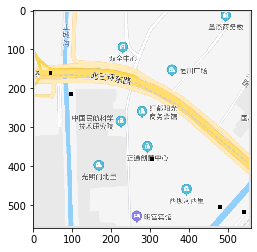

In [134]:
map_grid = cv.imread('beijing5.png')
max_len = 6
enter_point, exit_point = get_random_enter_exit_point(map_grid, 'left','right', 0.8, None)
pred = predict(decoder, encoder, map_grid[:,:,::-1] / 200, enter_point, exit_point, max_len)
pred = pred.detach().cpu().numpy().reshape((max_len, 2))
pred = np.clip(pred, -1, 1)

img = visualize(map_grid, pred, None, enter_point, exit_point)
# cv.imshow('', img)
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

plt.imshow(img)
plt.show()

In [131]:
from PIL import Image, ImageDraw

img = visualize_line(map_grid, pred, None, enter_point, exit_point)


405 3
404 48
399 99
318 317
217 484
187 542
